In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import numpy as np
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [4]:
df_csv = pd.read_csv('天然气（清洗）.csv',encoding='gb2312')
df_csv.head()

,日期,收盘,开盘,高,低,涨跌幅,交易量
0,2022/3/1,4.573,4.408,4.627,4.340,3.88%,112.55
1,2022/3/2,4.762,4.600,4.911,4.600,4.13%,141.69
2,2022/3/3,4.722,4.795,4.936,4.628,-0.84%,137.15
3,2022/3/4,5.016,4.750,5.045,4.728,6.23%,125.39
4,2022/3/7,4.833,5.041,5.184,4.781,-3.65%,130.86


In [5]:
data = df_csv
data['日期'] = pd.to_datetime(data['日期'])

In [6]:
# 再次清洗一遍，把涨跌幅的格式转为float方便画图
data['涨跌幅'] = data['涨跌幅'].str.rstrip('%').astype(float) / 100.0

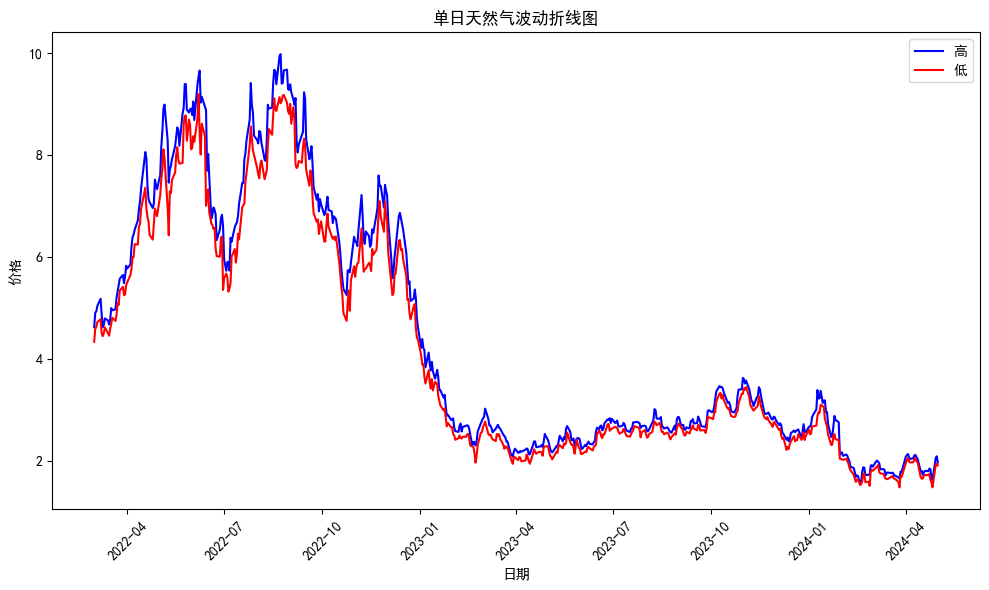

In [5]:
# 单日天然气波动折线图
oil_high = data['高']
oil_low = data['低']
dates = data['日期']

# 绘制折线图
plt.figure(figsize=(10, 6))
plt.plot(dates, oil_high, label='高', color='blue')
plt.plot(dates, oil_low, label='低', color='red')
plt.xlabel('日期')
plt.ylabel('价格')
plt.title('单日天然气波动折线图')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()


d:\python 3.80\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\python 3.80\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\python 3.80\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\python 3.80\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\python 3.80\lib\site-packages\statsmodels

                               SARIMAX Results                                
Dep. Variable:                     收盘   No. Observations:                  575
Model:                 ARIMA(0, 2, 1)   Log Likelihood                  -3.528
Date:                Tue, 21 May 2024   AIC                             11.056
Time:                        00:13:51   BIC                             19.758
Sample:                             0   HQIC                            14.450
                                - 575                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0000      1.981     -0.505      0.614      -4.883       2.883
sigma2         0.0586      0.116      0.506      0.613      -0.168       0.286
Ljung-Box (L1) (Q):                   2.33   Jarque-

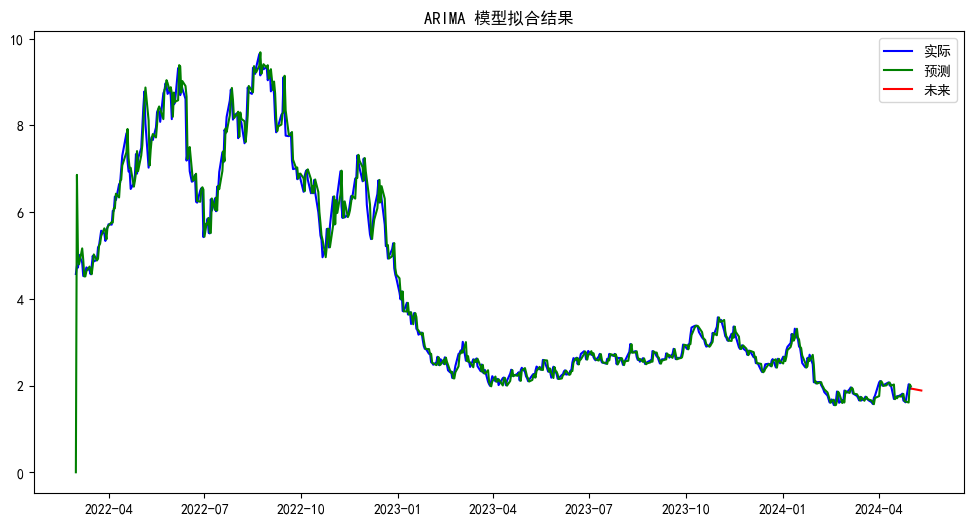

In [7]:
#基于时间序列模型(ARIMA模型)对未来天然气价格变化趋势的预测

# 设置日期为索引
# 跑一次够了，第二次跑会报错
# data.set_index('日期', inplace=True)

# 创建 ARIMA 模型
model = ARIMA(data['收盘'], order=(0,2,1)) # MA(1)模型  二阶差分 详见ARIMA参数确认(天然气) 

# 拟合 ARIMA 模型
model_fit = model.fit()

# 打印概要
print(model_fit.summary())

# 进行未来价格预测
future_steps = 10  # 想更改预测天数改这里
forecast = model_fit.forecast(steps=future_steps)
print("未来价格预测值：", forecast)

# 创建未来日期序列
future_dates = pd.date_range(start=data.index[-1], periods=future_steps + 1, freq=data.index.freq)[1:]

# 绘制拟合图
plt.figure(figsize=(12, 6))
plt.plot(data['收盘'], color='blue', label='实际')
plt.plot(model_fit.fittedvalues, color='green', label='预测')
plt.plot(future_dates, forecast, color='red', label='未来')
plt.legend()
plt.title('ARIMA 模型拟合结果')
plt.show()

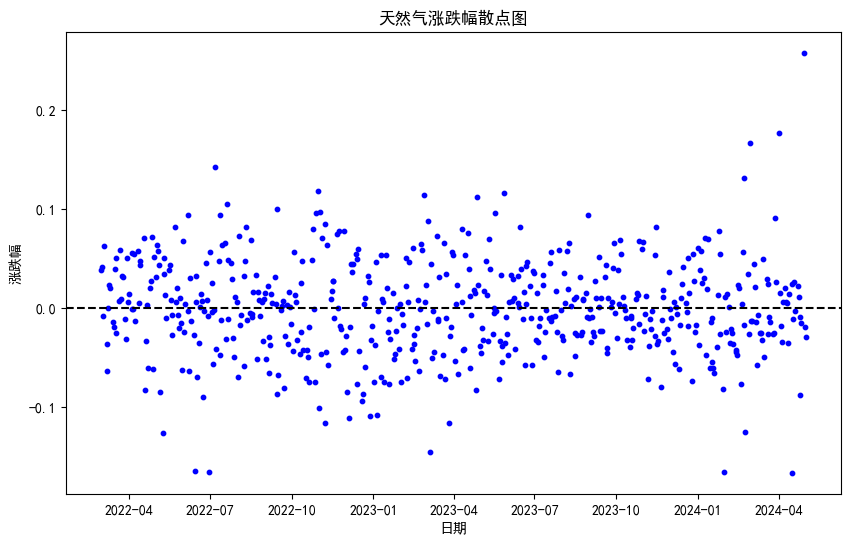

In [17]:
# 涨跌幅散点图
plt.figure(figsize=(10,6))
plt.scatter(data['日期'], data['涨跌幅'], color='b', marker='o', s=10)
plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel('日期')
plt.ylabel('涨跌幅')
plt.title('天然气涨跌幅散点图')
plt.show()

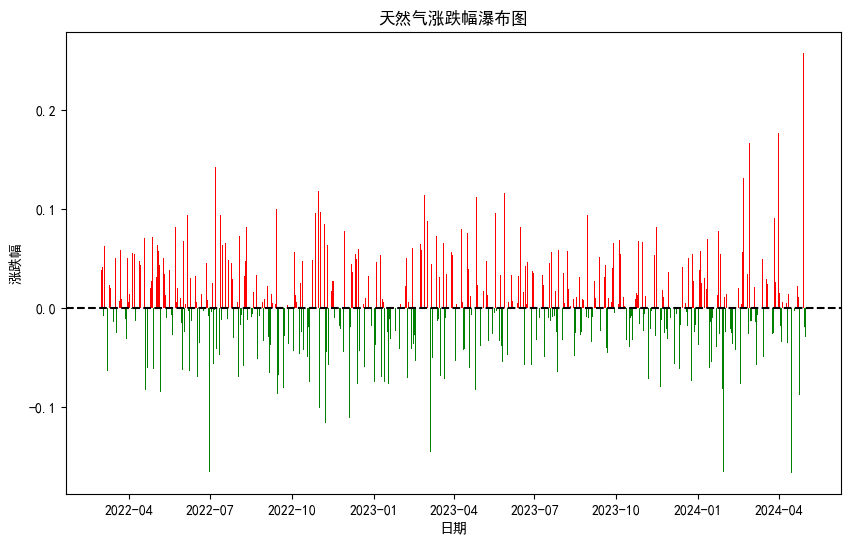

In [18]:
# 瀑布图
plt.figure(figsize=(10,6))
plt.bar(data['日期'], data['涨跌幅'], color=['r' if x >= 0 else 'g' for x in data['涨跌幅']], width=0.8)
plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel('日期')
plt.ylabel('涨跌幅')
plt.title('天然气涨跌幅瀑布图')
plt.show()

斜率 : -5.916204331700483e-06
截距 : 0.0019422133253773786


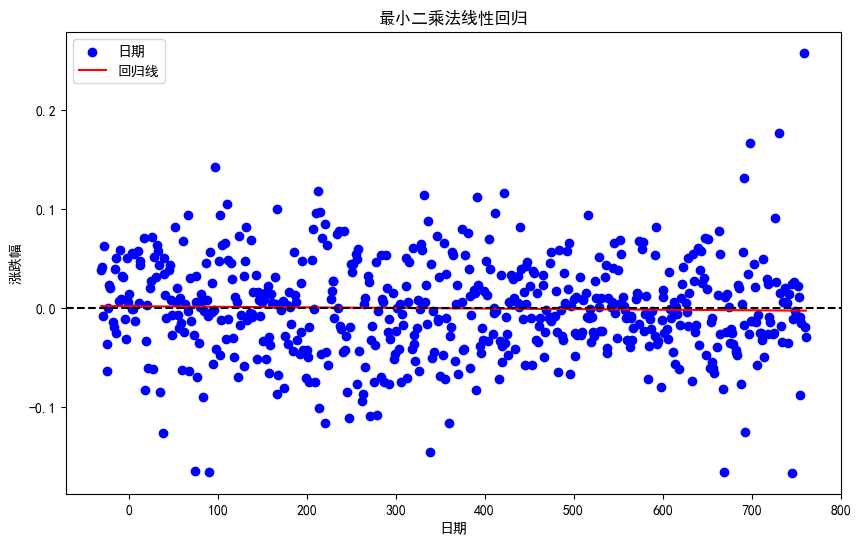

In [19]:
# 涨跌幅的最小二乘法线性回归分析

# 将日期转换为自某一固定日期以来的天数
# xy轴必须得是同类型的数据不然会报错
start_date = pd.Timestamp('2022-04-01')  
new_dates = (data['日期'] - start_date).dt.days.astype(float)

X = new_dates.values.reshape(-1, 1)  
y = data['涨跌幅'].values

# 创建模型
model = LinearRegression()

# 拟合模型
model.fit(X, y)

# 打印斜率与截距
slope = model.coef_[0]
intercept = model.intercept_
print("斜率 :", slope)
print("截距 :", intercept)

# 绘制散点图和回归线
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='b', marker='o', label='日期')
plt.plot(X, model.predict(X), color='r', label='回归线')
plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel('日期')
plt.ylabel('涨跌幅')
plt.title('最小二乘法回归线(天然气)')
plt.legend()
plt.show()

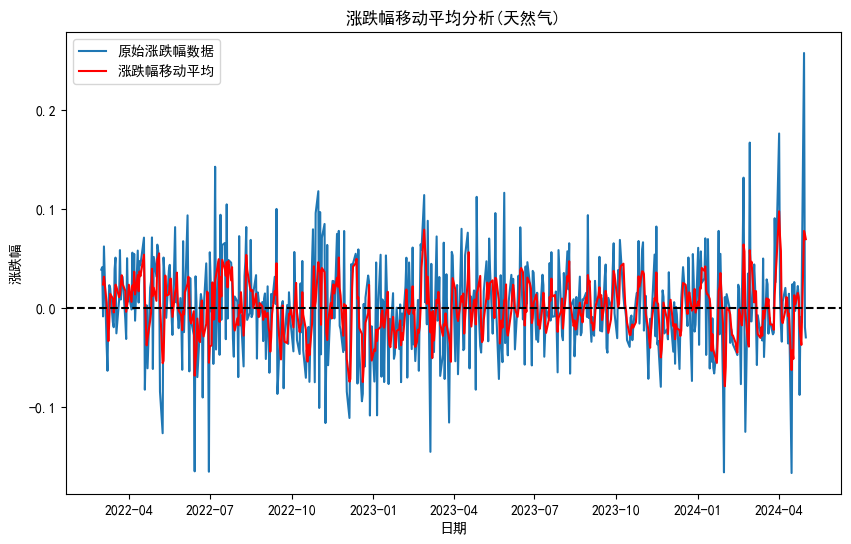

In [20]:
# 涨跌幅散点图的移动平均分析
window_size = 3 #改周期在这改
data['移动平均'] = data['涨跌幅'].rolling(window=window_size).mean()

#绘图
plt.figure(figsize=(10,6))
plt.plot(data['日期'], data['涨跌幅'], label='原始涨跌幅数据')
plt.plot(data['日期'], data['移动平均'], label='涨跌幅移动平均', color='red')
plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel('日期')
plt.ylabel('涨跌幅')
plt.title('涨跌幅移动平均分析(天然气)')
plt.legend()
plt.show()


In [12]:
# 查看数据描述
data.describe()

,日期,收盘,开盘,高,低,涨跌幅,交易量,移动平均
count,575,575.000000,575.000000,575.000000,575.000000,575.000000,575.000000,573.000000
mean,2023-03-31 06:25:40.173912832,4.230026,4.245157,4.381854,4.094191,-0.000213,750.649165,-0.000237
min,2022-03-01 00:00:00,1.551000,1.527000,1.565000,1.481000,-0.166600,0.000000,-0.078900
25%,2022-09-13 12:00:00,2.464000,2.455500,2.558000,2.388000,-0.031000,76.340000,-0.018333
50%,2023-03-30 00:00:00,2.899000,2.891000,2.960000,2.820000,-0.000700,115.680000,-0.000533
75%,2023-10-14 12:00:00,6.311000,6.337000,6.596000,6.060000,0.031450,153.905000,0.016633
max,2024-05-01 00:00:00,9.647000,9.780000,9.987000,9.200000,0.257700,23156.000000,0.097800
std,NaN,2.344839,2.349427,2.438902,2.255242,0.049430,2819.577591,0.027085
